In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


아래의 CLASSES의 이름은 다운 받은 폴더의 이름이 일치해야 합니다. ex) data/train

In [2]:
# 우리가 분류할 8개의 클래스
#CLASSES = [ 'car', 'cat', 'bottle', 'bus', 'bicycle', 'bird', 'boat', 'aeroplane' ]
classes = []

학습에 필요한 상수 정의

In [3]:
from pathlib import Path

# 학습에 필요한 상수들을 정의 합니다.
IMG_SHAPE = (224, 224, 3)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 10

# 각 이미지의 기본 주소
BASE_PATH = './drive/MyDrive/Colab Notebooks/data/'
images_dir = Path(BASE_PATH).expanduser()
print(images_dir)

drive/MyDrive/Colab Notebooks/data


내 드라이브 파일 마운트하고, 폴더 정보 읽어오기

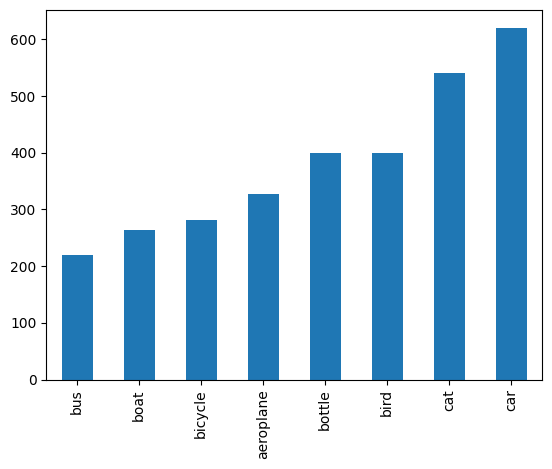

bus          219
boat         264
bicycle      281
aeroplane    328
bottle       399
bird         399
cat          540
car          621
dtype: int64


In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# 모델 학습에 사용할 데이터 정보를 설정합니다.
class_list = []
num_list = []

# IMAGE_BASE_PATH = './data/'
train_path = BASE_PATH + 'train/'
for folder in os.listdir(train_path):
    classes.append(folder)
    folder_size = len(os.listdir(train_path+folder))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

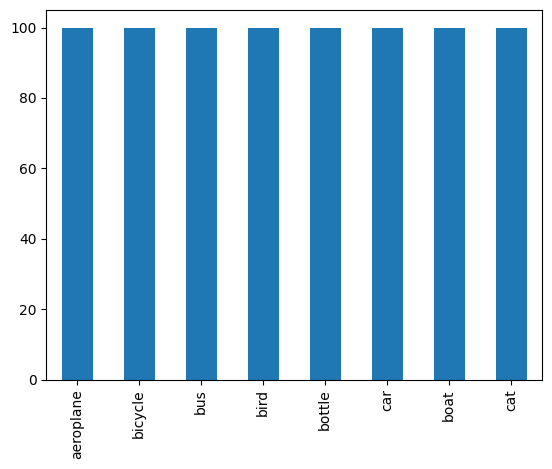

aeroplane    100
bicycle      100
bus          100
bird         100
bottle       100
car          100
boat         100
cat          100
dtype: int64


In [5]:
# 모델 학습 검증에 사용할 데이터 내용 입니다.

class_list = []
num_list = []

#IMAGE_BASE_PATH = './data/'
valid_path = BASE_PATH + 'val/'
for folder in os.listdir(valid_path):
    folder_size = len(os.listdir(valid_path+folder))
#     print('{:<15} : {}'.format(folder,folder_size))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

**Transfer Learning 을 통해 적은 데이터를 가지고 빠르게 학습시키기**

여기서는 기존 weight(가중치) 값을 이용하여 데이터를 학습시킵니다.

In [6]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, MobileNetV2

# base model 의 input shape, 그리고  trainable 을 false 로 합니다.

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

Transfer Learning 에서 정확성을 높이기 위해 마지막 3개 block 에서 모델 트레이닝합니다.

In [7]:
from tqdm import tqdm
# tqdm: progress bar를 표시해주는 패키지

# transfer learning에서 마지막 3개 block 을 사용하여 모델을 트레이닝 합니다.
set_trainable = False
for layer in tqdm(base_model.layers):
    if layer.name in ['block_14_expand','block_15_expand', 'block_16_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

100%|██████████| 154/154 [00:00<00:00, 38571.77it/s]


In [8]:
# 레이어 구성을 살펴 봅니다.

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer objec...,input_1,False
1,<keras.src.layers.convolutional.conv2d.Conv2D ...,Conv1,False
2,<keras.src.layers.normalization.batch_normaliz...,bn_Conv1,False
3,<keras.src.layers.activation.relu.ReLU object ...,Conv1_relu,False
4,<keras.src.layers.convolutional.depthwise_conv...,expanded_conv_depthwise,False
...,...,...,...
149,<keras.src.layers.convolutional.conv2d.Conv2D ...,block_16_project,True
150,<keras.src.layers.normalization.batch_normaliz...,block_16_project_BN,True
151,<keras.src.layers.convolutional.conv2d.Conv2D ...,Conv_1,True
152,<keras.src.layers.normalization.batch_normaliz...,Conv_1_bn,True


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 2947208 (11.24 MB)
Trainable params: 68922

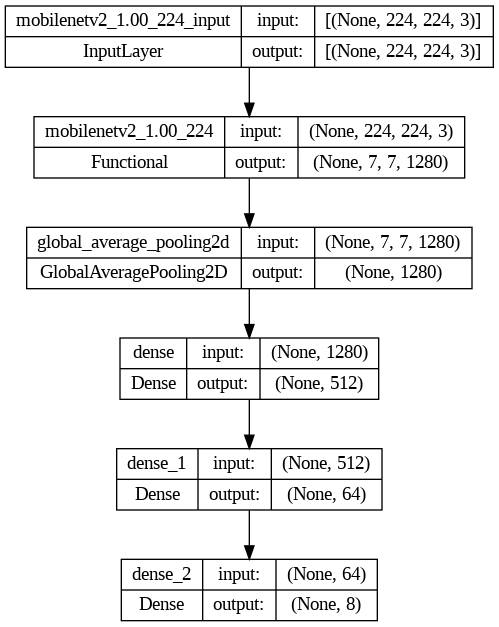

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

# 모델 만들기, 기존 모델의 weight 값을 사용하고 pooling 과 activation 함수를 추가 합니다.

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(len(classes), activation='softmax')
])
model.summary()

png_file = BASE_PATH+'mobilenet_model.png'
plot_model(model,to_file=png_file,show_shapes=True)

모델 컴파일

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.0001), # transfer learning 여기서 학습률을 더 작게
              metrics=['acc'])

학습 모델 정보 설정하기

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 트레인 데이터 augmentation 의로 데이터를 증가 시킴니다.

train_datagen = ImageDataGenerator(rotation_range=30,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

train_set = train_datagen.flow_from_directory(BASE_PATH + 'train/',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode='categorical')

Found 3051 images belonging to 8 classes.


In [12]:
# 학습중에 validation에 사용할 데이터셋 입니다.

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_set = valid_datagen.flow_from_directory(BASE_PATH + 'val/',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode='categorical')

Found 800 images belonging to 8 classes.


In [13]:
# 학습을 완료후에 모델 성능 테스트에 사용할 데이터셋 입니다.

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(BASE_PATH + 'val/',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode='categorical')

Found 800 images belonging to 8 classes.


In [14]:
# 모델 트레이닝 입니다.

history = model.fit_generator(train_set,
                              steps_per_epoch=train_set.n // train_set.batch_size,
                              epochs=20,
                              validation_data=valid_set,
                              validation_steps=valid_set.n // valid_set.batch_size,
#                               use_multiprocessing=True,
                              )

<ipython-input-14-199a79ffbc6f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,


Epoch 1/20
190/190 [==============================] - 704s 4s/step - loss: 1.2727 - acc: 0.5779 - val_loss: 0.7360 - val_acc: 0.7850
Epoch 2/20
190/190 [==============================] - 204s 1s/step - loss: 0.8473 - acc: 0.7259 - val_loss: 0.6473 - val_acc: 0.8238
Epoch 3/20
190/190 [==============================] - 206s 1s/step - loss: 0.7735 - acc: 0.7387 - val_loss: 0.6158 - val_acc: 0.8238
Epoch 4/20
190/190 [==============================] - 190s 999ms/step - loss: 0.7486 - acc: 0.7516 - val_loss: 0.6349 - val_acc: 0.8050
Epoch 5/20
190/190 [==============================] - 183s 961ms/step - loss: 0.7166 - acc: 0.7578 - val_loss: 0.6027 - val_acc: 0.8125
Epoch 6/20
190/190 [==============================] - 197s 1s/step - loss: 0.6925 - acc: 0.7671 - val_loss: 0.6460 - val_acc: 0.7975
Epoch 7/20
190/190 [==============================] - 200s 1s/step - loss: 0.6752 - acc: 0.7667 - val_loss: 0.6271 - val_acc: 0.8037
Epoch 8/20
190/190 [==============================] - 198s 1s/s

학습된 모델을 저장

In [15]:
#model.save(BASE_PATH+'bin/mobilenetv2_class8.h5')
model.save(BASE_PATH+'bin/mobilenetv2_class8.tf')

test_set.class_indices.items()

In [16]:
import pickle

# key 와 value 값을 바꾸어 줍니다.
class8 = dict()
for key,value in test_set.class_indices.items():
    class8[value] = key

with open(BASE_PATH+'bin/class8.pickle', 'wb') as f:
    pickle.dump(class8, f)

In [17]:
class8

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat'}

모델 평가하기

In [18]:
# 트레인 데이터와 테스트 데이터 셋으로 loss 와 accuracy 측정합니다.

train_loss, train_acc = model.evaluate_generator(train_set)
print('Train Loss : {}'.format(train_loss))
print('Train Accuracy : {}'.format(train_acc))

test_loss, test_acc = model.evaluate_generator(test_set)
print('Test Loss : {}'.format(test_loss))
print('Test Accuracy : {}'.format(test_acc))

<ipython-input-18-d90b856d67ed>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = model.evaluate_generator(train_set)


Train Loss : 0.44869333505630493
Train Accuracy : 0.8315306305885315


<ipython-input-18-d90b856d67ed>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_set)


Test Loss : 0.6682081818580627
Test Accuracy : 0.7925000190734863


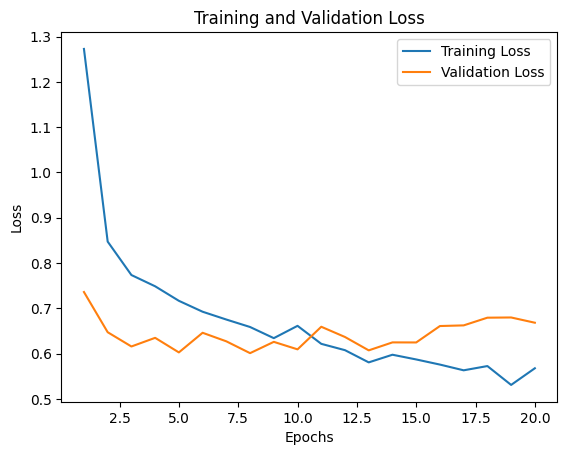

In [19]:
# loss 측정값의 시각화 입니다.

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

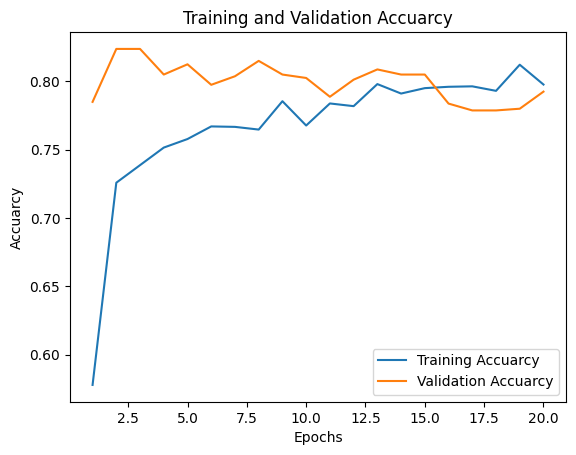

In [20]:
# accuracy 측정값의 시각화 입니다.

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(loss)+1)
plt.plot(epochs,acc,label='Training Accuarcy')
plt.plot(epochs,val_acc,label='Validation Accuarcy')
plt.title('Training and Validation Accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend()

plt.show()

모델 테스트해보기

In [30]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np

# 추론하기 위한 작업입니다. 모델 설정, 입력 데이터 전처리.
def predict_test_img(path):
    img = cv2.imread(path)

    model = load_model(BASE_PATH+'bin/mobilenetv2_class8.tf')

    print('Original Shape : ',img.shape)

    img = cv2.resize(img, (224,224), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    print('Resized Shape : ',img.shape)
    plt.imshow(img)
    plt.show()
    class8 = []

    predicted_result = model.predict(np.expand_dims(img,axis=0))
    ans = np.round(predicted_result).astype(int)
    with open(BASE_PATH+'bin/class8.pickle','rb') as f:
        class8 = pickle.load(f)
    res = -1
    for x in range(8):
      if ans[0][x] == 1: res = x
    print('Predict : {}'.format(class8[res]))

    pd.DataFrame(predicted_result,columns=class8.values()).iloc[0].plot(kind='bar')
    plt.show()

Original Shape :  (375, 500, 3)
Resized Shape :  (224, 224, 3)


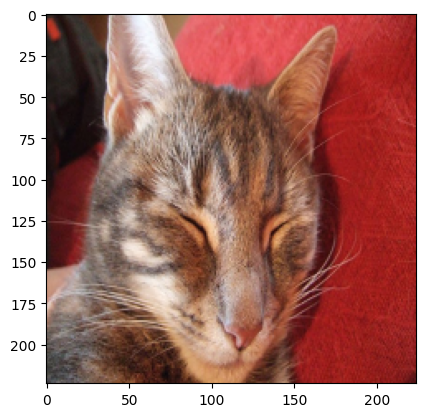

1/1 [==============================] - 1s 837ms/step
Predict : cat


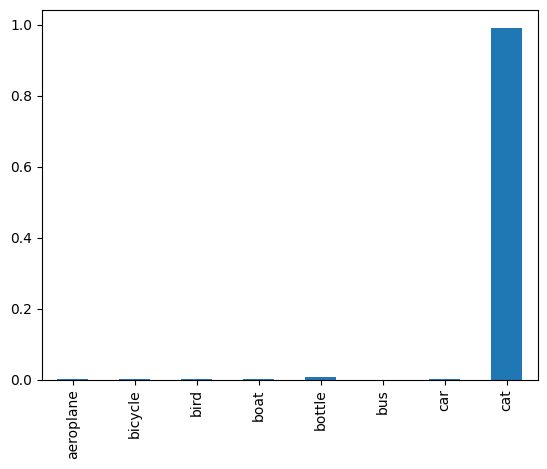

In [31]:
# 기존에 사용되지 않았던 임의 데이터를 추론 하기
predict_test_img(BASE_PATH+'val/cat/2008_000056.jpg')